# Investigating Factors of Rising House Values in New York City: Step 3: Machine Learning

Team Members: Francisco Brady (fbrady), Zhonghan Xie (jonasxie), Michael Garner (mngarner)  
Date: 2024-12-02

## Introduction

In this section, we seek to apply clustering machine learning techniques to the combined New York City housing price, education, eviction, and demographic dataset in order to identify patterns and relationships between these phenomena. 

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import scale
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [2]:
# Import merged neighborhood-level dataset
allData = pd.read_csv('./data/analytic_dataset.csv')

## Preprocessing
- Data cleaning and handling of issues: 20 points
- Feature scaling and normalization; one-hot encoding/categorical variable handling: 20 points
- Dimensionality reduction techniques: 20 points
- Preprocessing justification and impact analysis: 20 points

In [3]:
# Streamline dataset to keep columns of interest for this analysis
keepCols = ['year', 'nta_name', 'borough', 'pct_attendance',
       'pct_chronically_absent', 'EVICTION_COUNT', 'GEOID',
       'median_sale_price', 'hvi', 'total_population',
       'median_income', 'white_pct', 'black_pct',
       'american_indian_alaska_native_pct', 'asian_pct',
       'hawaiian_pacific_islander_pct', 'multiple_race_pct', 'other_race_pct']
data = allData[keepCols]

# Rename column for format
data.rename(columns={'EVICTION_COUNT': 'num_evictions'}, inplace=True)

# Drop rows with missing values
data = data.dropna()
data.sample(10)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_4248\1098084363.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={'EVICTION_COUNT': 'num_evictions'}, inplace=True)


,year,nta_name,borough,pct_attendance,pct_chronically_absent,num_evictions,GEOID,median_sale_price,hvi,total_population,median_income,white_pct,black_pct,american_indian_alaska_native_pct,asian_pct,hawaiian_pacific_islander_pct,multiple_race_pct,other_race_pct
61213,2020.0,Kingsbridge Heights-Van Cortlandt Village,Bronx,94.233902,16.666666,5.0,36005027900,642500.0,362262.507362,7884.0,30157.0,24.937,14.815,1.065,4.820,0.292,28.995,39.574
34898,2019.0,College Point,Queens,94.341766,17.154255,3.0,36081090700,889000.0,741144.023110,1391.0,24688.0,33.357,0.000,0.000,37.599,0.000,4.170,26.959
15126,2019.0,Coney Island-Sea Gate,Brooklyn,92.353210,26.767677,5.0,36047035200,630000.0,437267.108750,1162.0,11368.0,65.146,23.494,0.000,7.401,0.000,0.861,3.528
22431,2022.0,Canarsie,Brooklyn,82.281868,52.083332,1.0,36047099800,790000.0,622969.128486,3624.0,41224.0,6.595,88.107,0.000,0.883,0.000,1.325,3.753
17730,2022.0,Bedford-Stuyvesant (West),Brooklyn,77.632156,73.320160,5.0,36047026100,1650000.0,986130.726784,4798.0,42111.0,24.594,50.271,1.313,2.418,0.542,25.427,8.149
17791,2019.0,Bushwick (East),Brooklyn,91.340805,33.720932,7.0,36047040300,950000.0,793043.569721,3697.0,31329.0,24.777,58.913,3.219,3.138,0.000,11.577,4.166
8292,2020.0,Brownsville,Brooklyn,87.019409,45.047924,6.0,36047091600,681375.0,522927.586739,3196.0,17642.0,6.915,77.628,0.000,0.532,0.000,13.517,8.166
55292,2022.0,Tremont,Bronx,85.983734,56.870228,3.0,36005036502,767500.0,341490.981049,2482.0,17408.0,8.985,33.763,0.927,0.000,0.000,35.536,38.558
26418,2019.0,Kensington,Brooklyn,96.705109,4.672897,3.0,36047048800,1562500.0,729512.054494,4044.0,36778.0,49.332,6.083,0.000,27.596,0.000,22.156,5.910
29785,2019.0,East Harlem (North),Manhattan,92.041550,30.933851,26.0,36061018400,2143750.0,943952.192506,7387.0,20425.0,21.985,48.328,1.584,5.821,0.000,5.009,19.778


In [4]:
# Show duplicate GEOIDs
data[data.duplicated(subset='GEOID')]


,year,nta_name,borough,pct_attendance,pct_chronically_absent,num_evictions,GEOID,median_sale_price,hvi,total_population,median_income,white_pct,black_pct,american_indian_alaska_native_pct,asian_pct,hawaiian_pacific_islander_pct,multiple_race_pct,other_race_pct
21,2020.0,Sunset Park (West),Brooklyn,93.977356,19.429590,1.0,36047007400,1300000.0,615567.384006,5328.0,23235.0,33.296,0.638,1.126,30.593,0.0,9.685,29.505
23,2020.0,Sunset Park (West),Brooklyn,93.977356,19.429590,2.0,36047007800,1300000.0,615567.384006,4873.0,26467.0,51.365,2.298,0.882,8.496,0.0,6.321,33.798
26,2020.0,Sunset Park (West),Brooklyn,93.977356,19.429590,1.0,36047008400,1300000.0,615567.384006,3635.0,26059.0,45.667,2.779,1.486,5.309,0.0,8.638,40.440
28,2020.0,Sunset Park (West),Brooklyn,93.977356,19.429590,1.0,36047010100,1300000.0,615567.384006,3944.0,40087.0,50.989,4.184,3.271,9.026,0.0,22.211,21.425
33,2020.0,Sunset Park (West),Brooklyn,93.977356,19.429590,6.0,36047002200,1300000.0,615567.384006,4284.0,26005.0,55.042,5.999,0.000,10.994,0.0,5.042,25.444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65448,2022.0,Mott Haven-Port Morris,Bronx,56.050163,88.120949,5.0,36005005100,820000.0,685357.770663,5858.0,15515.0,15.961,32.127,0.000,0.666,0.0,7.614,47.439
65449,2022.0,Mott Haven-Port Morris,Bronx,56.050163,88.120949,2.0,36005003500,820000.0,685357.770663,3738.0,20773.0,15.008,43.526,2.461,0.000,0.0,15.195,31.407
65450,2022.0,Mott Haven-Port Morris,Bronx,56.050163,88.120949,1.0,36005004100,820000.0,685357.770663,5865.0,16763.0,18.227,40.341,2.728,0.597,0.0,25.814,25.200
65451,2022.0,Mott Haven-Port Morris,Bronx,56.050163,88.120949,9.0,36005004300,820000.0,685357.770663,5421.0,17007.0,21.878,31.396,0.221,1.623,0.0,29.404,30.179


In [5]:
# data.num_evictions.describe()

In [6]:
# reshape data
# reshape data to have one row per neighborhood
# take evictions, hvi, and median sale price and reshape by year
# everything else can be aggregated by mean
# convert year to no decimal string before reshape
data['year'] = data['year'].astype(int).astype(str)
# define function to pull variables and reshape to wide format
# also interpolates missing values
def reshape_data(data, value_col, index_col, columns_col):
    # Create the pivot table
    data_pivot = data.pivot_table(index=[index_col], columns=columns_col, values=value_col)
    # Interpolate missing values
    data_pivot = data_pivot.interpolate(method='linear', axis=1)    
    data_pivot.reset_index(inplace=True)    
    # Rename columns to include the value_col prefix for clarity
    data_pivot.columns = [index_col] + [f'{value_col}_{col}' for col in data_pivot.columns[1:]]    
    return data_pivot


In [7]:
evict_pivot = reshape_data(data, 'num_evictions', 'nta_name', 'year')
hvi_pivot = reshape_data(data, 'hvi', 'nta_name', 'year')
sale_price_pivot = reshape_data(data, 'median_sale_price', 'nta_name', 'year')

In [8]:
# Collapse to one row for each neighborhood
data.drop(columns=['GEOID'], inplace=True)
data = data.groupby(['nta_name', 'borough']).agg({
    'pct_attendance': 'mean',
    'pct_chronically_absent': 'mean',
    'total_population': 'mean',
    'median_income': 'mean',
    'white_pct': 'mean',
    'black_pct': 'mean',
    'american_indian_alaska_native_pct': 'mean',
    'asian_pct': 'mean',
    'hawaiian_pacific_islander_pct': 'mean',
    'multiple_race_pct': 'mean',
    'other_race_pct': 'mean'
}).reset_index()


In [9]:
# Merge in reshaped data
data = data.merge(evict_pivot, on='nta_name', how='left')
data = data.merge(hvi_pivot, on='nta_name', how='left')
data = data.merge(sale_price_pivot, on='nta_name', how='left')

                                 nta_name        borough  pct_attendance  \
0  Annadale-Huguenot-Prince's Bay-Woodrow  Staten Island       90.908173   
1                       Astoria (Central)         Queens       93.794789   
2         Astoria (East)-Woodside (North)         Queens       91.716040   
3        Astoria (North)-Ditmars-Steinway         Queens       93.550828   
4                            Baisley Park         Queens       86.424383   

   pct_chronically_absent  total_population  median_income  white_pct  \
0               26.137263       6365.833333   51494.666667  93.866917   
1               19.178189       4200.217391   53675.130435  62.310522   
2               26.626202       2675.125000   38265.083333  59.745375   
3               20.996938       3189.500000   48089.607143  72.516250   
4               44.085725       2206.869565   32745.847826   5.066826   

   black_pct  american_indian_alaska_native_pct  asian_pct  ...  \
0   1.808000                         

In [10]:
data.head()

,nta_name,borough,pct_attendance,pct_chronically_absent,total_population,median_income,white_pct,black_pct,american_indian_alaska_native_pct,asian_pct,...,num_evictions_2021,num_evictions_2022,hvi_2019,hvi_2020,hvi_2021,hvi_2022,median_sale_price_2019,median_sale_price_2020,median_sale_price_2021,median_sale_price_2022
0,Annadale-Huguenot-Prince's Bay-Woodrow,Staten Island,90.908173,26.137263,6365.833333,51494.666667,93.866917,1.808000,0.000000,2.430167,...,1.000000,1.25,555499.363294,550402.839163,565244.293110,617570.552311,795000.0,769000.0,825000.0,929500.0
1,Astoria (Central),Queens,93.794789,19.178189,4200.217391,53675.130435,62.310522,2.515783,0.984913,17.909304,...,1.000000,1.50,810890.207402,790067.820665,768519.860276,771594.666048,1157500.0,1300000.0,1200000.0,1248000.0
2,Astoria (East)-Woodside (North),Queens,91.716040,26.626202,2675.125000,38265.083333,59.745375,5.943583,0.286042,16.515625,...,1.757143,1.80,810890.207402,790067.820665,780831.243356,771594.666048,1157500.0,1300000.0,1274000.0,1248000.0
3,Astoria (North)-Ditmars-Steinway,Queens,93.550828,20.996938,3189.500000,48089.607143,72.516250,3.075250,0.215893,9.791071,...,1.466667,1.60,810890.207402,790067.820665,780831.243356,771594.666048,1157500.0,1300000.0,1274000.0,1248000.0
4,Baisley Park,Queens,86.424383,44.085725,2206.869565,32745.847826,5.066826,68.072326,0.117739,7.896174,...,1.500000,2.00,405046.524528,418482.728411,423075.233739,425119.568484,635000.0,631325.0,680000.0,580000.0


In [11]:
# Add column to categorize white/minority-dominated neighborhoods
data['minority_dominated'] = np.where((100 - data['white_pct']) > 50, "Yes", "No")
data.sample(5)

,nta_name,borough,pct_attendance,pct_chronically_absent,total_population,median_income,white_pct,black_pct,american_indian_alaska_native_pct,asian_pct,...,num_evictions_2022,hvi_2019,hvi_2020,hvi_2021,hvi_2022,median_sale_price_2019,median_sale_price_2020,median_sale_price_2021,median_sale_price_2022,minority_dominated
11,Bellerose,Queens,91.246968,27.280999,5158.000000,43240.727273,27.964091,10.660364,1.620909,42.513182,...,1.250000,603056.003160,627556.783445,667930.796140,708304.808836,680000.0,647500.0,726750.0,806000.0,Yes
9,Bedford-Stuyvesant (East),Brooklyn,87.006197,45.929289,3873.086526,34923.461030,19.480536,62.626498,0.339318,4.570957,...,3.050000,881176.891001,905406.301449,931092.569110,986130.726784,1250000.0,1320000.0,1462500.0,1650000.0,Yes
105,Rosedale,Queens,91.334495,30.619905,3476.058824,40006.352941,7.692471,83.498000,0.557118,2.571294,...,1.200000,559607.785909,590754.097227,636184.394752,681614.692278,678822.0,760000.0,805000.0,850000.0,Yes
10,Bedford-Stuyvesant (West),Brooklyn,85.561947,51.002435,4046.478502,36953.008322,38.316014,42.810473,0.437824,3.973225,...,2.888889,881176.891001,905406.301449,931092.569110,986130.726784,1250000.0,1320000.0,1462500.0,1650000.0,Yes
6,Bay Ridge,Brooklyn,93.823018,17.866042,3028.629032,43245.193548,68.013565,3.784565,0.192823,15.133226,...,1.954545,985867.809108,907188.144896,908566.583954,890611.144833,1247500.0,1200000.0,1300000.0,1300000.0,No


In [12]:
# Separate data into features and a label
X = data.drop(['nta_name'], axis=1)
y = data['nta_name']

In [13]:
# Build preprocessing pipelines
catCols = ['borough', 'minority_dominated']
numCols = X.columns.drop(catCols)
numPC = 4 # Number of principal components to use

# Numerical variable pipeline
numPipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define column transformer
preprocessor = ColumnTransformer([
    ('num', numPipe, numCols),
    ('cat', OneHotEncoder(), catCols)
])

# Pipeline with dimension reduction
fullPipe = Pipeline([
    ('prep', preprocessor),
    ('pca', PCA(n_components=numPC))
])

In [14]:
# Fit and transform features
X_pca = fullPipe.fit_transform(X)

In [15]:
# Report percent of variance explained by PCA with 4 components
evr = fullPipe.named_steps['pca'].explained_variance_ratio_
print(f"Percent variance retained in first {numPC} PCs: {100*evr}%")
print(f"Sum of percent variance explained by first 4 PCs: {100*sum(evr):.2f}%")

Percent variance retained in first 4 PCs: [37.54465707 17.53298024  8.56416373  5.43434603]%
Sum of percent variance explained by first 4 PCs: 69.08%


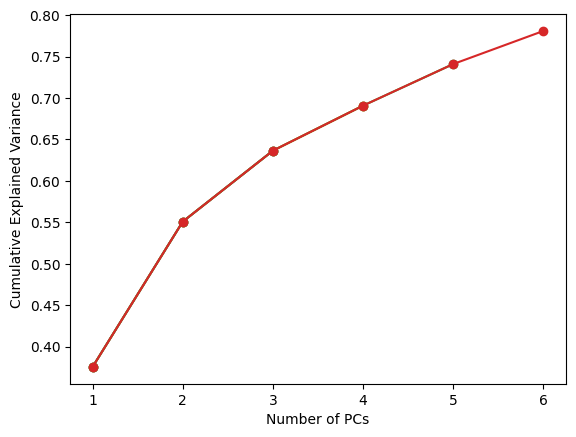

In [16]:
# Try different number of principal components to finetune the PCA model
for numPC in range(3,7):
    fullPipe.named_steps['pca'].n_components = numPC
    X_pca = fullPipe.fit_transform(X)
    evr = fullPipe.named_steps['pca'].explained_variance_ratio_
    plt.plot(range(1, numPC+1), np.cumsum(evr), marker="o", label=f'{numPC} PCs')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [18]:
# Report percent of variance explained by PCA with 5 components
fullPipe.named_steps['pca'].n_components = 5
X_pca = fullPipe.fit_transform(X)
evr = fullPipe.named_steps['pca'].explained_variance_ratio_
print(f"Percent variance retained in first {numPC} PCs: {100*evr}%")
print(f"Sum of percent variance explained by first 5 PCs: {100*sum(evr):.2f}%")

Percent variance retained in first 6 PCs: [37.54465707 17.53298024  8.56416373  5.43434603  5.01932643]%
Sum of percent variance explained by first 5 PCs: 74.10%


## Clustering Analysis
- Clear definition and justification of goals: 10 points
- Implementation of chosen techniques: 20 points
- Parameter optimization and method tuning: 20 points
- Performance evaluation and metric selection: 20 points
- Interpretation and discussion of results: 30 points

Goals of Clustering Analysis:
1. Identify patterns and relationships between housing prices, education, eviction rates, and demographics in New York City.
2. Determine if there are distinct clusters of neighborhoods in New York City based on these factors.

### Agglomerative Clustering

In [19]:
# Agglomerative Clustering
numClusters = 3
agg = AgglomerativeClustering(n_clusters=numClusters)
aggClusters = agg.fit_predict(X_pca)

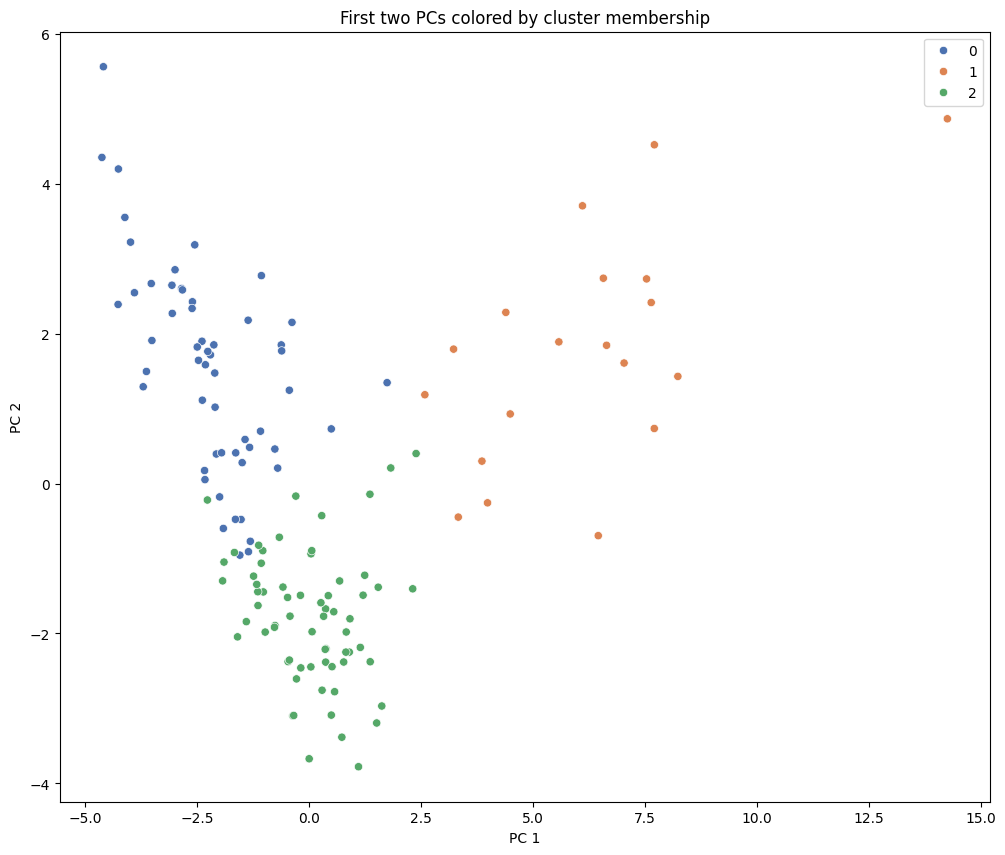

In [20]:
# Plot first two PCs with cluster assignments
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=aggClusters, palette='deep')
plt.title("First two PCs colored by cluster membership")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

In [21]:
# Group by cluster membership
X_clusters = X.copy()
X_clusters.drop(columns=catCols, inplace=True)
X_clusters["ClusterNumber"] = aggClusters
X_clusters.groupby("ClusterNumber").mean().T

ClusterNumber,0,1,2
pct_attendance,88.883543,8.981746e+01,9.256693e+01
pct_chronically_absent,38.632094,3.083675e+01,2.404010e+01
total_population,4143.594905,5.306983e+03,3.794755e+03
median_income,29496.212786,8.083965e+04,3.809329e+04
white_pct,21.409309,7.342341e+01,5.167335e+01
black_pct,47.904318,6.046078e+00,7.702253e+00
american_indian_alaska_native_pct,0.514540,1.507307e-01,4.519039e-01
asian_pct,4.981096,1.160224e+01,2.207392e+01
hawaiian_pacific_islander_pct,0.080342,4.790019e-02,4.101592e-02
multiple_race_pct,11.237599,1.047129e+01,1.085665e+01


### K-Means Clustering

In [28]:
silhouetteScores = []
fullPipe.named_steps['pca'].n_components = 4
X_pca = fullPipe.fit_transform(X)
for n_clusters in range(2, 8):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusterLabels = kmeans.fit_predict(X_pca)
    silhouetteScore = silhouette_score(X_pca, clusterLabels)
    silhouetteScores.append(silhouetteScore)
    print("For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouetteScore)
    
# Report clustering with best silhouette score
print("The best silhouette score is", max(silhouetteScores),
        "using", silhouetteScores.index(max(silhouetteScores)) + 2, "clusters")

For n_clusters = 2 The average silhouette_score is : 0.4901942914074016
For n_clusters = 3 The average silhouette_score is : 0.3792030352138077
For n_clusters = 4 The average silhouette_score is : 0.337496829662413
For n_clusters = 5 The average silhouette_score is : 0.29510770925465324
For n_clusters = 6 The average silhouette_score is : 0.3540718265088927
For n_clusters = 7 The average silhouette_score is : 0.3371597312342755
The best silhouette score is 0.4901942914074016 using 2 clusters


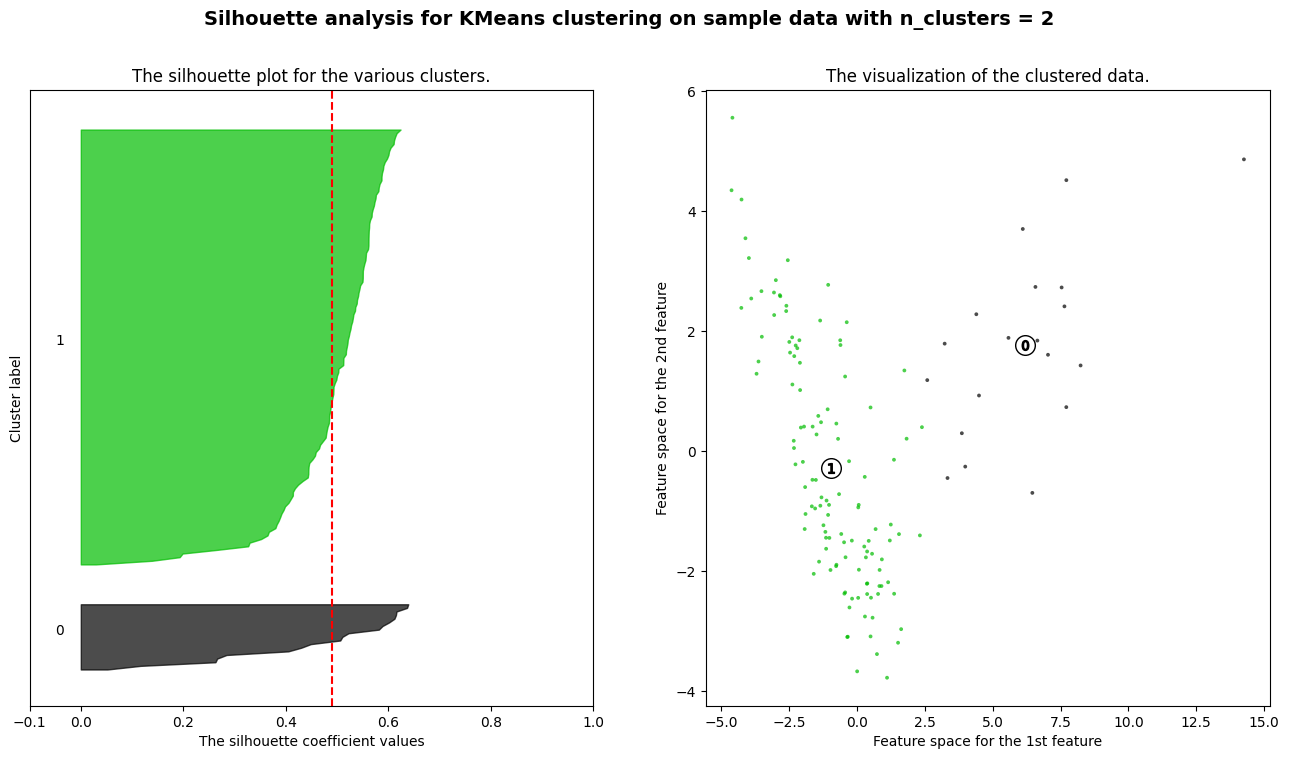

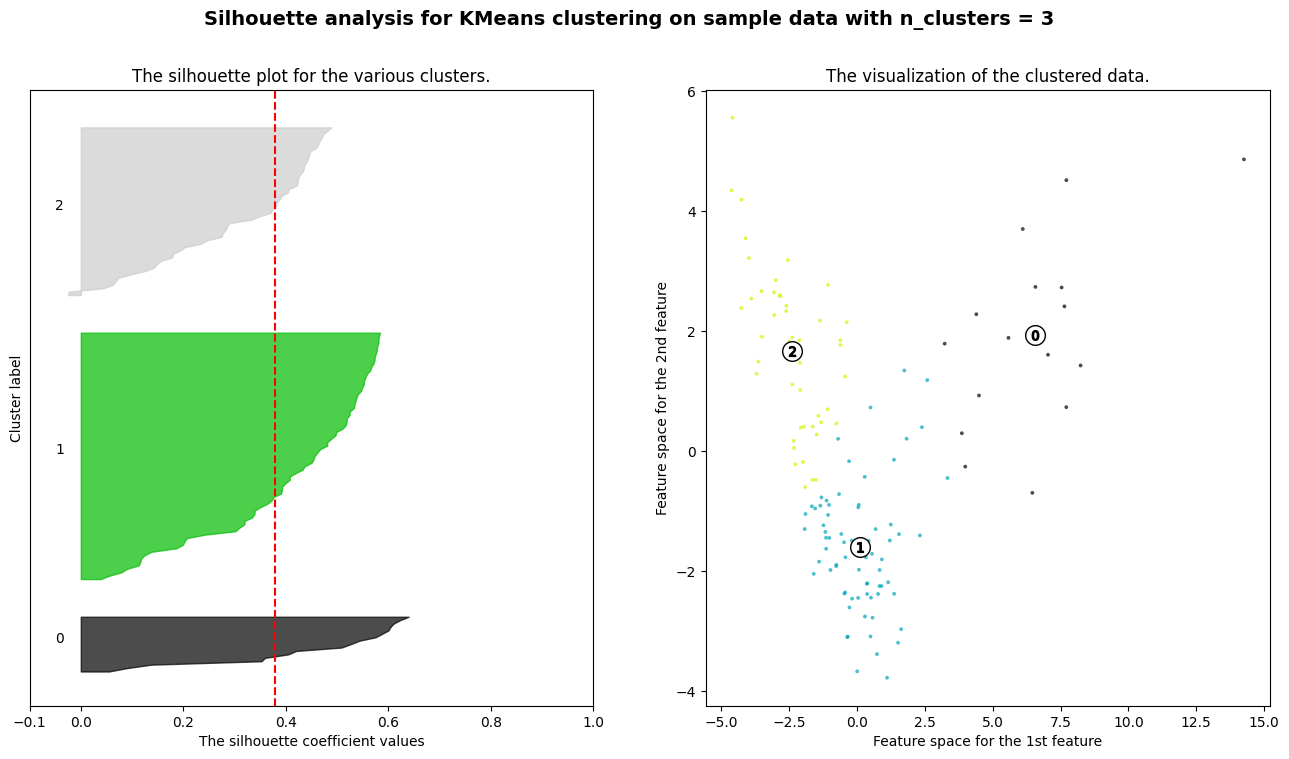

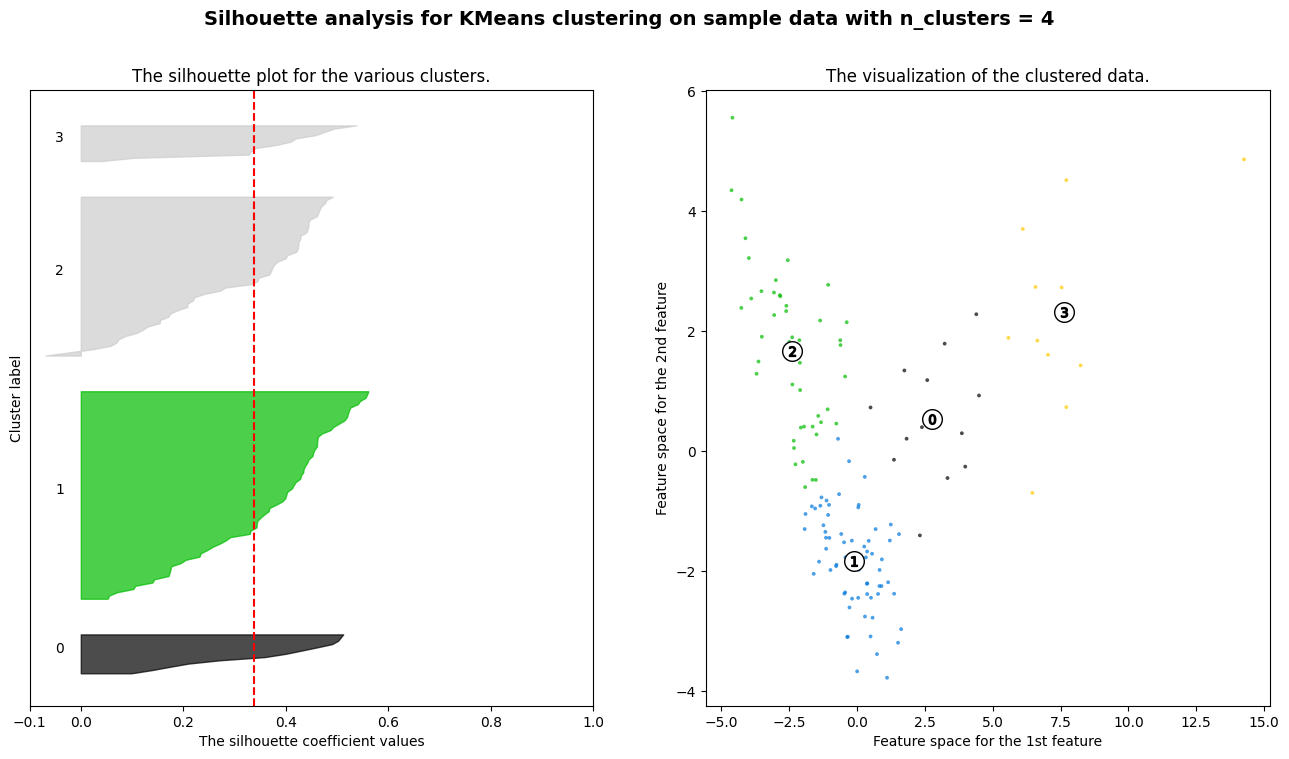

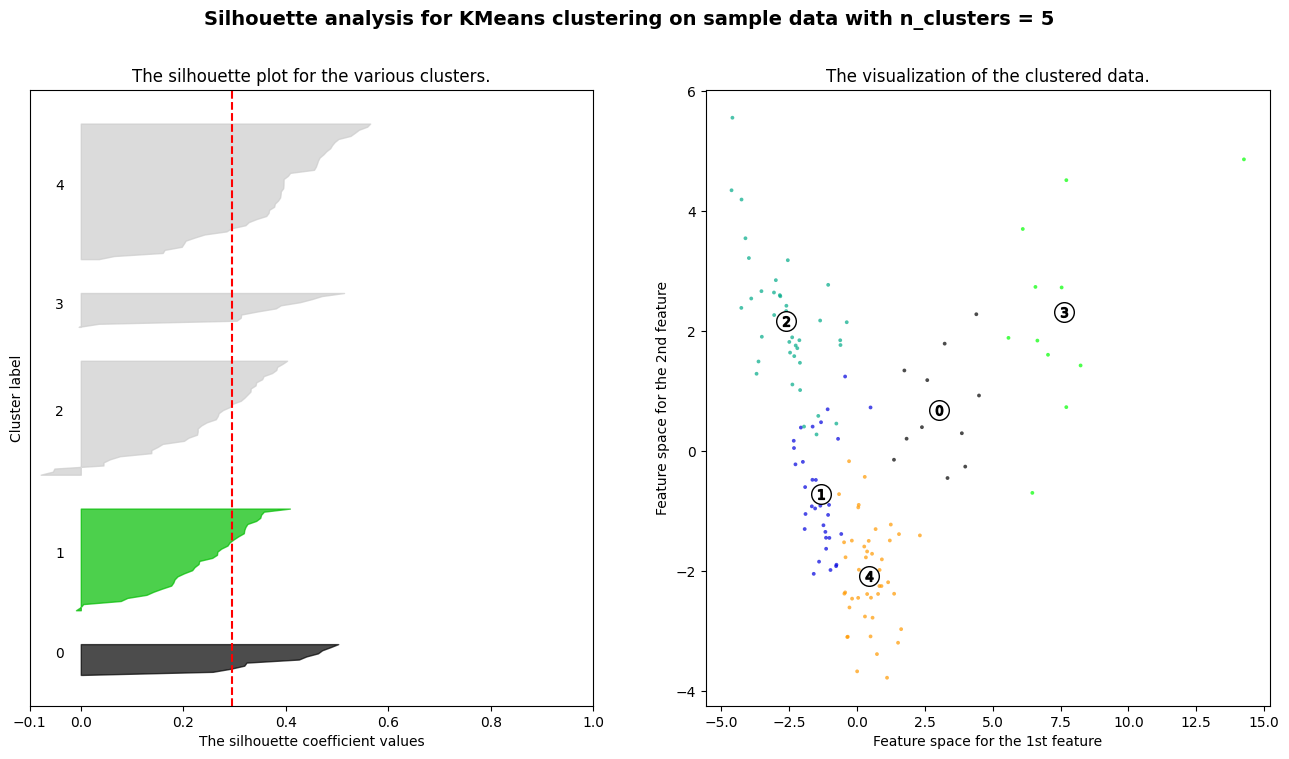

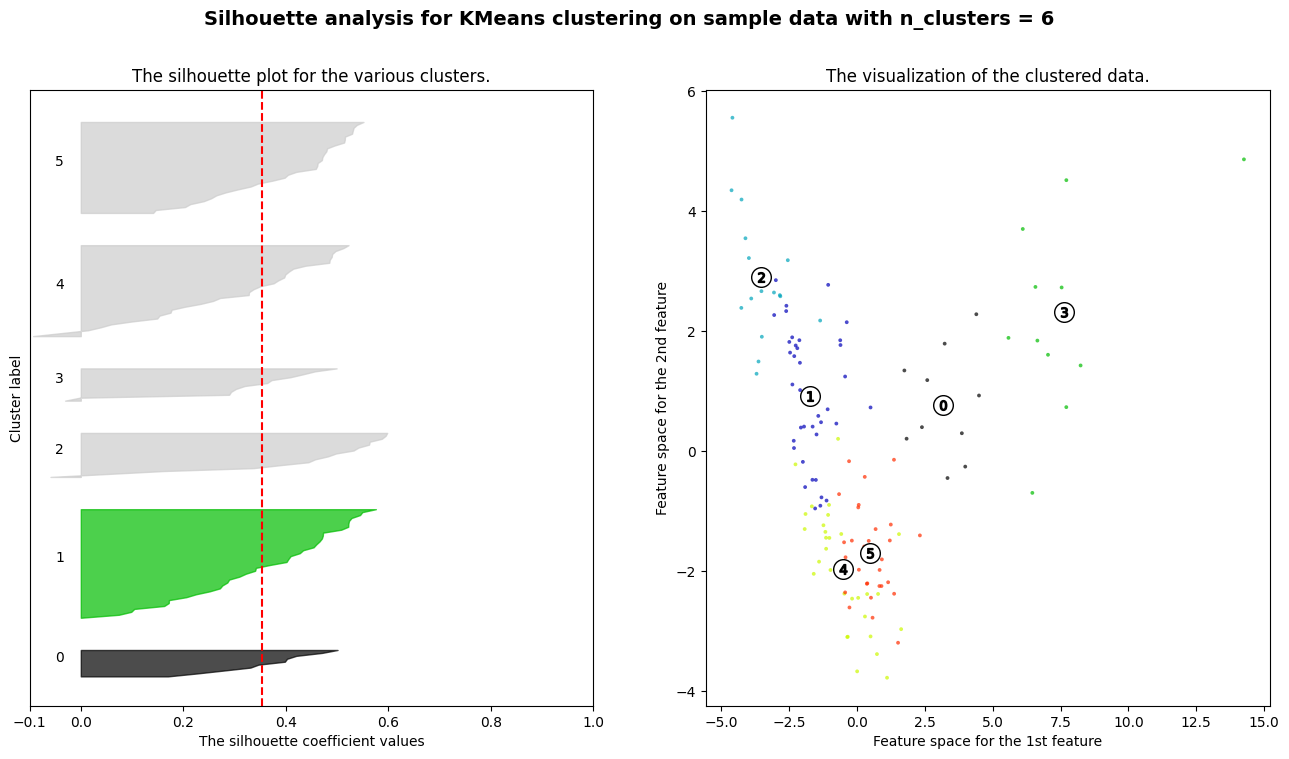

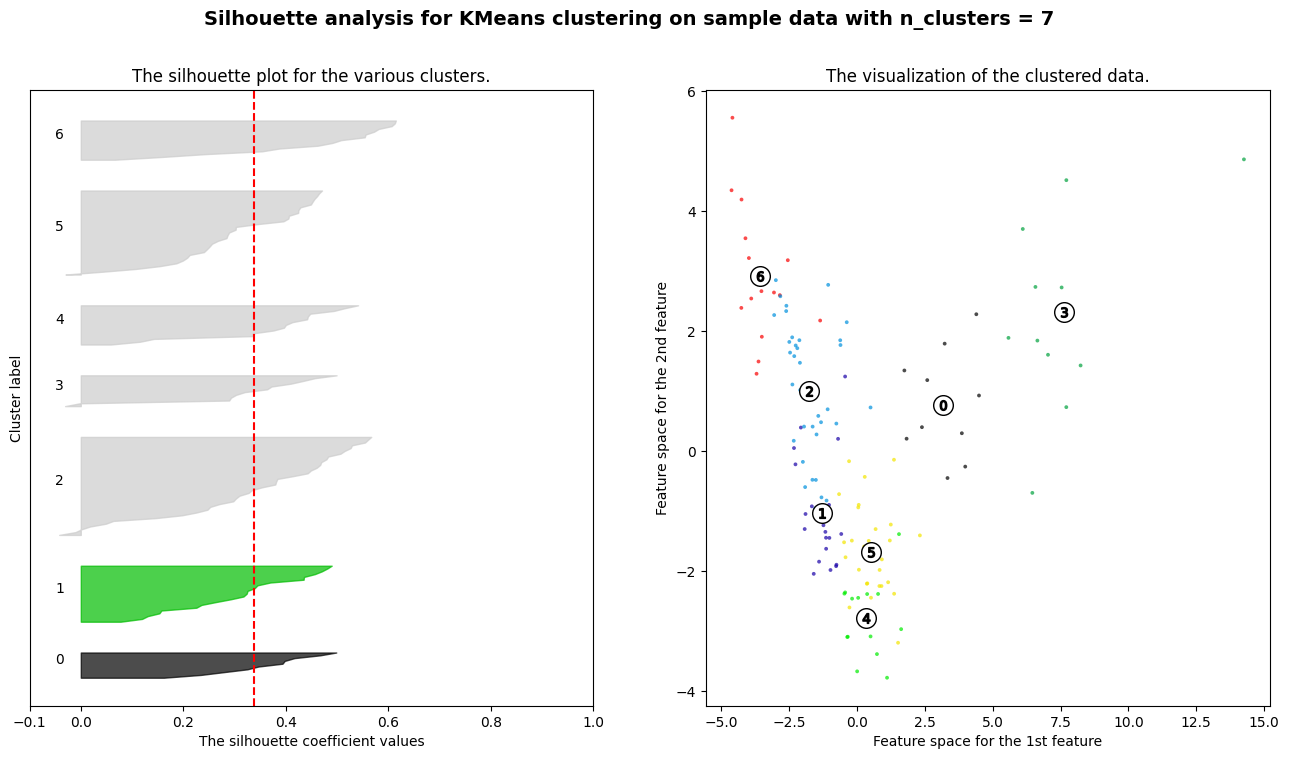

In [29]:
# Silhouette plots to determine optimal number of clusters: modified from lecture code
for n_clusters in range(2, 8):
    km = KMeans(n_clusters=n_clusters, random_state=42)
    clusterLabels = km.fit_predict(X_pca)
    avgSilOpt = silhouette_score(X_pca, clusterLabels)
    sampleSilVals = silhouette_samples(X_pca, clusterLabels)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sampleSilVals[clusterLabels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / 2)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=avgSilOpt, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(clusterLabels.astype(float) / n_clusters)
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = km.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                    f"with n_clusters = {n_clusters}"),
                    fontsize=14, fontweight='bold')

    plt.show()

In [30]:
# Group by cluster membership
X_km= X.copy()
X_km.drop(columns=catCols, inplace=True)
kmeans = KMeans(n_clusters=2, random_state=42)
clusterLabels = kmeans.fit_predict(X_pca)
X_km["Cluster"] = clusterLabels
X_km.groupby("Cluster").mean().T

Cluster,0,1
pct_attendance,8.981746e+01,9.089267e+01
pct_chronically_absent,3.083675e+01,3.067282e+01
total_population,5.306983e+03,3.953319e+03
median_income,8.083965e+04,3.418553e+04
white_pct,7.342341e+01,3.791697e+01
black_pct,6.046078e+00,2.597592e+01
american_indian_alaska_native_pct,1.507307e-01,4.803748e-01
asian_pct,1.160224e+01,1.430445e+01
hawaiian_pacific_islander_pct,4.790019e-02,5.889150e-02
multiple_race_pct,1.047129e+01,1.102981e+01


**Interpretation of Clustering Results**
The clustering mainly shows two different types of neighborhoods in New York City: Wealthier neighborhoods, predominantly White and higher property value areas with lower eviction rates; economically disadvantaged neighborhoods, racially diverse communities with lower property values and higher eviction rates.
1. Cluster 0 has much higher house sale prices than Cluster 1 on average, \$6410000 vs. \$1078000 in 2022. Cluster 0 also has much higher house value than Cluster 1, \$1.7M vs. 0.7M in 2022.
2. Cluster 0 has a less number of evictions than Cluster 1 from 2019 to 2022.
3. Cluster 0 is more populous (~5,307) than Cluster 1 (~3,953).
4. White population is predominant in Cluster 0 (73.4%) but lower in Cluster 1 (37.9%). Black population is higher in Cluster 1 (25.9%) than in Cluster 0 (6.0%).Other racial categories, particularly "other race" (15.7%) and "American Indian/Alaska Native" (0.48%), are more represented in Cluster 1 than in Cluster 0 (3.5% and 0.15%, respectively).

The clustering results reveal the intersection between socio-economic status and residential segregation in New York City neighborhoods. Wealthier neighborhoods tend to be predominantly White. Racially diverse neighborhoods tend to have lower median income and lower housing wealth. 
